In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
def create_random_text(dataframe, input_text_col_name, num_words_col_name, size_of_output, seed):
    np.random.seed(seed)
    
    min_num_words = dataframe[num_words_col_name].min()
    max_num_words = dataframe[num_words_col_name].max()
    
    def choose_random_word(dataframe, input_text_col_name, is_start, is_end):
        random_index = np.random.randint(0, dataframe.shape[0] - 1)
        df_random_sentence = dataframe[input_text_col_name].iloc[random_index]
        while df_random_sentence == "#NAME?":
            random_index = np.random.randint(0, dataframe.shape[0] - 1)
            df_random_sentence = dataframe[input_text_col_name].iloc[random_index]
        if is_start:
            return df_random_sentence.split(' ')[0]  
        if is_end:
            return df_random_sentence.split(' ')[-1]
        index_words = df_random_sentence.split(' ')[1:-1]
        return np.random.choice(index_words)
    
    store_sentences = []
    for i in range(size_of_output):
        sentence_num_words = np.random.randint(min_num_words, max_num_words)
        sentence = choose_random_word(dataframe, input_text_col_name, True, False) # Choose first word
        for j in range(sentence_num_words - 1 - 1): # -1 for first word already chosen, -1 for ending word
            sentence += ' ' + choose_random_word(dataframe, input_text_col_name, False, False)
        sentence += ' ' + choose_random_word(dataframe, input_text_col_name, False, True) #Choose last word
        store_sentences.append(sentence)
    
    return pd.DataFrame({input_text_col_name: store_sentences})

def create_stratified_label_df_column(original_column, column_name, out_df_length):
    df = original_column.copy()
    return df.groupby(column_name, group_keys=False).apply(lambda x: x.sample(int(np.rint(out_df_length*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

def create_metadata_df_column(original_column, meta_name, out_df_length):
    df = original_column.copy()
    df = df.squeeze()
    test = pd.DataFrame(np.random.choice(df,size=(out_df_length, 1)), columns=[meta_name])
    return test
    
def create_random_df(dataframe, input_text_col_name, num_words_col_name, size_of_output, seed, label_columns_list, meta_data_columns_list):
    # Start with input text column
    random_df = create_random_text(dataframe, input_text_col_name, num_words_col_name, size_of_output, seed)
    
    # Add the columns of label columns
    for label in label_columns_list:
        label_column = create_stratified_label_df_column(dataframe[label].to_frame(), label, size_of_output)
        random_df = random_df.join(label_column)
    
    # Add the columns of metadata columns
    for meta in meta_data_columns_list:
        meta_column = create_metadata_df_column(dataframe[meta].to_frame(), meta, size_of_output)
        random_df = random_df.join(meta_column)
    return random_df

In [3]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

In [4]:
# Set if want use random_df or not
is_random = True
random_df_size = df.shape[0]
seed = 160121
columns_list = ['Input.deception_quadrant', 'Answer.3rapport.yes_label',
                'Answer.4shareinformation.yes_label', 'Answer.2reasoning.yes_label',
                'Answer.1gamemove.yes_label', ]
meta_list = ['Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5',
             'WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5',
             'Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 'Answer.3rapport.yes_pc_agree',
             'Input.num_words', 'Input.num_characters']

if is_random:
    random_df = create_random_df(df, 'Input.full_text', 'Input.num_words', random_df_size, seed, columns_list, meta_list)
    drop_list = ['Input.full_text', 'Input.deception_quadrant', 'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Answer.2reasoning.yes_label', 'Answer.1gamemove.yes_label']
    random_df = random_df.drop(drop_list, axis=1)
    list_to_replace = list(random_df)
    df.drop(labels=list_to_replace, axis="columns", inplace=True)
    df[list_to_replace] = random_df[list_to_replace]

TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


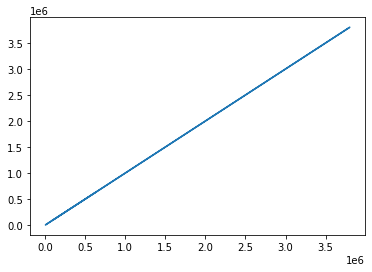

In [5]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP2'
worktime_option = 'WT1'
pc_agreement_option = 'PC1'
textlength_option = 'TL2'
special_option = 'SP1'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [6]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'cnn'
models_nn.MODEL_NAME = model_name

In [7]:
# # Old train_test_split code
# train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

In [8]:
print(df.shape, train.shape, test.shape)

(11366, 863) (9092, 863) (2274, 863)


In [9]:
# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.23.2


In [10]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 

In [11]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


In [12]:
X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [13]:
le = LabelEncoder()

# def label_preprocessing(y_data, label_encoder):
#     out = label_encoder.fit_transform(y_data).reshape(-1,1)
#     return out

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [14]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

### Construct individual  models

In [15]:
# Rapport model
rapport_model = models_nn.create_nn_model()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                              models_nn.recall_m, models_nn.precision_m])
rapport_model.fit(X_train,y_train_rapport,
                  batch_size=128,
                  epochs=50,
                  validation_data=(X_test, y_test_rapport), 
#                   callbacks=[models_nn.early_stop],
                  class_weight=rapport_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 1s 12ms/step - loss: 0.6949 - accuracy: 0.5606 - f1_m: 0.6409 - recall_m: 0.5825 - precision_m: 0.8375 - val_loss: 0.6774 - val_accuracy: 0.7792 - val_f1_m: 0.8726 - val_recall_m: 0.8749 - val_precision_m: 0.8712
Epoch 2/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6887 - accuracy: 0.5307 - f1_m: 0.6068 - recall_m: 0.5223 - precision_m: 0.8890 - val_loss: 0.7030 - val_accuracy: 0.4204 - val_f1_m: 0.5382 - val_recall_m: 0.3898 - val_precision_m: 0.8761
Epoch 3/50
72/72 [==============================] - 1s 7ms/step - loss: 0.6742 - accuracy: 0.5719 - f1_m: 0.6710 - recall_m: 0.5672 - precision_m: 0.9077 - val_loss: 0.6039 - val_accuracy: 0.7498 - val_f1_m: 0.8526 - val_recall_m: 0.8366 - val_precision_m: 0.8702
Epoch 4/50
72/72 [==============================] - 1s 7ms/step - loss: 0.6407 - accuracy: 0.6389 - f1_m: 0.7484 - recall_m: 0.6408 - precision_m: 0.9252 - val_loss: 0.7248 - val_accuracy: 0.4393 - val_f1_m:

Epoch 32/50
72/72 [==============================] - 0s 7ms/step - loss: 0.0594 - accuracy: 0.9747 - f1_m: 0.9853 - recall_m: 0.9744 - precision_m: 0.9966 - val_loss: 1.4267 - val_accuracy: 0.7573 - val_f1_m: 0.8574 - val_recall_m: 0.8440 - val_precision_m: 0.8721
Epoch 33/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0607 - accuracy: 0.9759 - f1_m: 0.9859 - recall_m: 0.9754 - precision_m: 0.9968 - val_loss: 1.4444 - val_accuracy: 0.7296 - val_f1_m: 0.8371 - val_recall_m: 0.8036 - val_precision_m: 0.8746
Epoch 34/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0567 - accuracy: 0.9776 - f1_m: 0.9869 - recall_m: 0.9761 - precision_m: 0.9981 - val_loss: 1.4736 - val_accuracy: 0.7634 - val_f1_m: 0.8614 - val_recall_m: 0.8508 - val_precision_m: 0.8730
Epoch 35/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0525 - accuracy: 0.9781 - f1_m: 0.9872 - recall_m: 0.9770 - precision_m: 0.9979 - val_loss: 1.5411 - val_accuracy: 0.7502 - val_f1

In [16]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

(0.5083528128408914, 0.5110813823473166, 0.5067784607895088, None)

In [17]:
# Game move model
gamemove_model = models_nn.create_nn_model()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                               models_nn.recall_m, models_nn.precision_m])
gamemove_model.fit(X_train,
                   y_train_gamemove,
                   batch_size=128,
                   epochs=50,
                   validation_data=(X_test, y_test_gamemove), 
#                    callbacks=[models_nn.early_stop],
                   class_weight=gamemove_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 1s 10ms/step - loss: 0.6939 - accuracy: 0.7471 - f1_m: 0.8159 - recall_m: 0.7917 - precision_m: 0.8771 - val_loss: 0.6774 - val_accuracy: 0.6253 - val_f1_m: 0.7597 - val_recall_m: 0.6348 - val_precision_m: 0.9483
Epoch 2/50
72/72 [==============================] - 1s 7ms/step - loss: 0.6894 - accuracy: 0.6537 - f1_m: 0.7655 - recall_m: 0.6676 - precision_m: 0.9394 - val_loss: 0.6581 - val_accuracy: 0.5862 - val_f1_m: 0.7265 - val_recall_m: 0.5887 - val_precision_m: 0.9511
Epoch 3/50
72/72 [==============================] - 1s 7ms/step - loss: 0.6760 - accuracy: 0.5974 - f1_m: 0.7097 - recall_m: 0.5971 - precision_m: 0.9480 - val_loss: 0.7300 - val_accuracy: 0.3443 - val_f1_m: 0.4733 - val_recall_m: 0.3168 - val_precision_m: 0.9532
Epoch 4/50
72/72 [==============================] - 1s 7ms/step - loss: 0.6493 - accuracy: 0.5488 - f1_m: 0.6835 - recall_m: 0.5388 - precision_m: 0.9644 - val_loss: 0.5162 - val_accuracy: 0.8056 - val_f1_m:

Epoch 32/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0392 - accuracy: 0.9870 - f1_m: 0.9930 - recall_m: 0.9872 - precision_m: 0.9991 - val_loss: 0.8259 - val_accuracy: 0.8637 - val_f1_m: 0.9262 - val_recall_m: 0.9144 - val_precision_m: 0.9387
Epoch 33/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0392 - accuracy: 0.9846 - f1_m: 0.9917 - recall_m: 0.9846 - precision_m: 0.9991 - val_loss: 0.7916 - val_accuracy: 0.8791 - val_f1_m: 0.9349 - val_recall_m: 0.9315 - val_precision_m: 0.9388
Epoch 34/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0333 - accuracy: 0.9872 - f1_m: 0.9931 - recall_m: 0.9872 - precision_m: 0.9992 - val_loss: 0.8722 - val_accuracy: 0.8443 - val_f1_m: 0.9147 - val_recall_m: 0.8924 - val_precision_m: 0.9387
Epoch 35/50
72/72 [==============================] - 1s 7ms/step - loss: 0.0317 - accuracy: 0.9889 - f1_m: 0.9941 - recall_m: 0.9891 - precision_m: 0.9992 - val_loss: 0.8816 - val_accuracy: 0.8536 - val_f1

In [18]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.508430713634368, 0.5131926644293529, 0.5076396024280688, None)

In [19]:
# Reasoning model
reasoning_model = models_nn.create_nn_model()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
reasoning_model.fit(X_train,
                    y_train_reasoning,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_reasoning), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=reasoning_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 1s 10ms/step - loss: 0.6937 - accuracy: 0.6493 - f1_m: 0.7226 - recall_m: 0.7152 - precision_m: 0.8327 - val_loss: 0.6768 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 2/50
72/72 [==============================] - 1s 7ms/step - loss: 0.6909 - accuracy: 0.5646 - f1_m: 0.6589 - recall_m: 0.5778 - precision_m: 0.8378 - val_loss: 0.7108 - val_accuracy: 0.3320 - val_f1_m: 0.3580 - val_recall_m: 0.2277 - val_precision_m: 0.8531
Epoch 3/50
72/72 [==============================] - 0s 7ms/step - loss: 0.6823 - accuracy: 0.5110 - f1_m: 0.6052 - recall_m: 0.4855 - precision_m: 0.8797 - val_loss: 0.6835 - val_accuracy: 0.5101 - val_f1_m: 0.6260 - val_recall_m: 0.5009 - val_precision_m: 0.8394
Epoch 4/50
72/72 [==============================] - 0s 7ms/step - loss: 0.6593 - accuracy: 0.6094 - f1_m: 0.7063 - recall_m: 0.6017 - precision_m: 0.9026 - val_loss: 0.7388 - val_accuracy: 0.3734 - val_f1_m:

Epoch 32/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0668 - accuracy: 0.9739 - f1_m: 0.9843 - recall_m: 0.9730 - precision_m: 0.9960 - val_loss: 1.5624 - val_accuracy: 0.6719 - val_f1_m: 0.7912 - val_recall_m: 0.7669 - val_precision_m: 0.8192
Epoch 33/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0646 - accuracy: 0.9742 - f1_m: 0.9843 - recall_m: 0.9730 - precision_m: 0.9962 - val_loss: 1.6105 - val_accuracy: 0.6719 - val_f1_m: 0.7914 - val_recall_m: 0.7668 - val_precision_m: 0.8198
Epoch 34/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0607 - accuracy: 0.9770 - f1_m: 0.9842 - recall_m: 0.9760 - precision_m: 0.9931 - val_loss: 1.6589 - val_accuracy: 0.6825 - val_f1_m: 0.7996 - val_recall_m: 0.7811 - val_precision_m: 0.8213
Epoch 35/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0613 - accuracy: 0.9751 - f1_m: 0.9850 - recall_m: 0.9738 - precision_m: 0.9966 - val_loss: 1.6190 - val_accuracy: 0.6825 - val_f1

In [20]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.514033050948117, 0.5145155856766344, 0.5142161446158641, None)

In [21]:
# Share Information model
shareinfo_model = models_nn.create_nn_model()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
shareinfo_model.fit(X_train,
                    y_train_share_information,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_share_information), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=share_info_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 1s 9ms/step - loss: 0.6937 - accuracy: 0.5980 - f1_m: 0.6515 - recall_m: 0.6424 - precision_m: 0.8372 - val_loss: 0.7151 - val_accuracy: 0.1772 - val_f1_m: 0.0594 - val_recall_m: 0.0310 - val_precision_m: 0.8083
Epoch 2/50
72/72 [==============================] - 1s 8ms/step - loss: 0.6916 - accuracy: 0.4965 - f1_m: 0.5690 - recall_m: 0.4830 - precision_m: 0.8708 - val_loss: 0.6539 - val_accuracy: 0.8047 - val_f1_m: 0.8898 - val_recall_m: 0.9378 - val_precision_m: 0.8478
Epoch 3/50
72/72 [==============================] - 0s 7ms/step - loss: 0.6819 - accuracy: 0.5940 - f1_m: 0.6931 - recall_m: 0.6146 - precision_m: 0.8808 - val_loss: 0.6137 - val_accuracy: 0.7823 - val_f1_m: 0.8747 - val_recall_m: 0.9039 - val_precision_m: 0.8492
Epoch 4/50
72/72 [==============================] - 1s 7ms/step - loss: 0.6598 - accuracy: 0.6350 - f1_m: 0.7377 - recall_m: 0.6460 - precision_m: 0.8969 - val_loss: 0.7010 - val_accuracy: 0.4631 - val_f1_m: 

Epoch 32/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0858 - accuracy: 0.9645 - f1_m: 0.9786 - recall_m: 0.9634 - precision_m: 0.9946 - val_loss: 1.2777 - val_accuracy: 0.7071 - val_f1_m: 0.8176 - val_recall_m: 0.7854 - val_precision_m: 0.8533
Epoch 33/50
72/72 [==============================] - 1s 8ms/step - loss: 0.0874 - accuracy: 0.9666 - f1_m: 0.9799 - recall_m: 0.9655 - precision_m: 0.9951 - val_loss: 1.3165 - val_accuracy: 0.6931 - val_f1_m: 0.8063 - val_recall_m: 0.7642 - val_precision_m: 0.8544
Epoch 34/50
72/72 [==============================] - 1s 9ms/step - loss: 0.0761 - accuracy: 0.9691 - f1_m: 0.9815 - recall_m: 0.9684 - precision_m: 0.9952 - val_loss: 1.3472 - val_accuracy: 0.7401 - val_f1_m: 0.8430 - val_recall_m: 0.8355 - val_precision_m: 0.8516
Epoch 35/50
72/72 [==============================] - 1s 9ms/step - loss: 0.0686 - accuracy: 0.9738 - f1_m: 0.9844 - recall_m: 0.9730 - precision_m: 0.9963 - val_loss: 1.4381 - val_accuracy: 0.6970 - val_f1

In [22]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

(0.5235139312159788, 0.5278689971751412, 0.5242318354845913, None)

In [23]:
# Deception model
deception_model = models_nn.create_nn_model()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
deception_model.fit(X_train,
                    y_train_deception,
                    epochs=50,
                    validation_data=(X_test, y_test_deception), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=deception_class_weight_dict)

Epoch 1/50
285/285 [==============================] - 1s 4ms/step - loss: 0.6970 - accuracy: 0.7425 - f1_m: 0.8100 - recall_m: 0.7717 - precision_m: 0.9475 - val_loss: 0.4715 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 2/50
285/285 [==============================] - 1s 4ms/step - loss: 0.7030 - accuracy: 0.5277 - f1_m: 0.6127 - recall_m: 0.5278 - precision_m: 0.9359 - val_loss: 0.7135 - val_accuracy: 0.0655 - val_f1_m: 0.0341 - val_recall_m: 0.0179 - val_precision_m: 0.4236
Epoch 3/50
285/285 [==============================] - 1s 4ms/step - loss: 0.6912 - accuracy: 0.5581 - f1_m: 0.6569 - recall_m: 0.5581 - precision_m: 0.9478 - val_loss: 0.6722 - val_accuracy: 0.2867 - val_f1_m: 0.4017 - val_recall_m: 0.2609 - val_precision_m: 0.9325
Epoch 4/50
285/285 [==============================] - 1s 4ms/step - loss: 0.6788 - accuracy: 0.5219 - f1_m: 0.6496 - recall_m: 0.5179 - precision_m: 0.9671 - val_loss: 0.5328 - val_accuracy: 0.9507 - va

Epoch 32/50
285/285 [==============================] - 1s 4ms/step - loss: 0.4494 - accuracy: 0.7389 - f1_m: 0.8392 - recall_m: 0.7333 - precision_m: 0.9900 - val_loss: 0.6080 - val_accuracy: 0.6284 - val_f1_m: 0.7626 - val_recall_m: 0.6395 - val_precision_m: 0.9537
Epoch 33/50
285/285 [==============================] - 1s 4ms/step - loss: 0.4510 - accuracy: 0.7410 - f1_m: 0.8395 - recall_m: 0.7351 - precision_m: 0.9886 - val_loss: 0.5261 - val_accuracy: 0.7137 - val_f1_m: 0.8263 - val_recall_m: 0.7335 - val_precision_m: 0.9525
Epoch 34/50
285/285 [==============================] - 1s 4ms/step - loss: 0.4354 - accuracy: 0.7476 - f1_m: 0.8453 - recall_m: 0.7433 - precision_m: 0.9897 - val_loss: 0.5800 - val_accuracy: 0.6601 - val_f1_m: 0.7866 - val_recall_m: 0.6749 - val_precision_m: 0.9530
Epoch 35/50
285/285 [==============================] - 1s 4ms/step - loss: 0.4186 - accuracy: 0.7631 - f1_m: 0.8560 - recall_m: 0.7586 - precision_m: 0.9898 - val_loss: 0.6002 - val_accuracy: 0.6649 

In [24]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.5101851851851852, 0.5269839434386151, 0.5013080956463668, None)

In [25]:
# deception_pred_test

In [26]:
# unique, counts = np.unique(deception_pred_test_round, return_counts=True)

In [27]:
# print(unique, counts)

In [28]:
# deception_model.history.history['val_f1_m']

### One hot encodings

In [29]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [30]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [32]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7062 - acc: 0.8586 - f1_m: 0.9233 - precision_m: 0.9516 - recall_m: 0.8978 - val_loss: 0.6339 - val_acc: 0.7828 - val_f

143/143 [==============================] - 0s 2ms/step - loss: 0.6938 - acc: 0.5400 - f1_m: 0.6203 - precision_m: 0.9470 - recall_m: 0.5496 - val_loss: 0.6895 - val_acc: 0.7062 - val_f1_m: 0.8248 - val_precision_m: 0.9487 - val_recall_m: 0.7311
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6938 - acc: 0.7741 - f1_m: 0.8475 - precision_m: 0.9456 - recall_m: 0.7991 - val_loss: 0.6959 - val_acc: 0.3127 - val_f1_m: 0.4436 - val_precision_m: 0.9576 - val_recall_m: 0.2914
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6938 - acc: 0.3102 - f1_m: 0.3846 - precision_m: 0.9479 - recall_m: 0.2959 - val_loss: 0.6928 - val_acc: 0.6860 - val_f1_m: 0.8100 - val_precision_m: 0.9495 - val_recall_m: 0.7079
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6937 - acc: 0.1882 - f1_m: 0.2517 - precision_m: 0.9458 - recall_m: 0.1564 - val_loss: 0.6980 - val_acc: 0.2581 - val_f1_m: 0.3694 - val_precision_m: 0.9586 - val_r

In [33]:
joint_predict = joint_full_model.predict(pred_test_df_full)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5044464206313917, 0.5167255847760011, 0.23358426763590795, None)

In [34]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1755  519]


In [35]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 4ms/step - loss: 0.7612 - acc: 0.1391 - f1_m: 0.0672 - precision_m: 0.4103 - recall_m: 0.0388 - val_loss: 0.7567 - val_acc: 0.2476 - val_f1_

143/143 [==============================] - 0s 2ms/step - loss: 0.6181 - acc: 0.8326 - f1_m: 0.9000 - precision_m: 0.9147 - recall_m: 0.8875 - val_loss: 0.7155 - val_acc: 0.7133 - val_f1_m: 0.8247 - val_precision_m: 0.8685 - val_recall_m: 0.7868
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6139 - acc: 0.8333 - f1_m: 0.9008 - precision_m: 0.9153 - recall_m: 0.8887 - val_loss: 0.7036 - val_acc: 0.7172 - val_f1_m: 0.8281 - val_precision_m: 0.8682 - val_recall_m: 0.7934
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6102 - acc: 0.8335 - f1_m: 0.9010 - precision_m: 0.9154 - recall_m: 0.8891 - val_loss: 0.6912 - val_acc: 0.7186 - val_f1_m: 0.8297 - val_precision_m: 0.8670 - val_recall_m: 0.7974
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6071 - acc: 0.8337 - f1_m: 0.9020 - precision_m: 0.9152 - recall_m: 0.8909 - val_loss: 0.6859 - val_acc: 0.7238 - val_f1_m: 0.8334 - val_precision_m: 0.8673 - val_r

In [36]:
joint_predict = joint_full_model.predict(pred_test_df)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.495683198686282, 0.49396743465654086, 0.49099810666545, None)

In [37]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 443 1831]


## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [38]:
# Train weighted encodings
pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)

In [39]:
# Test weighted encodings
pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)

## Throughput only

### Joint Model with one hot encoding 

In [40]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6937 - acc: 0.3471 - f1_m: 0.4404 - precision_m: 0.7046 - recall_m: 0.3328 - val_loss: 0.7066 -

143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.5806 - f1_m: 0.7254 - precision_m: 0.9532 - recall_m: 0.5889 - val_loss: 0.6918 - val_acc: 0.6324 - val_f1_m: 0.7684 - val_precision_m: 0.9531 - val_recall_m: 0.6465
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.6495 - f1_m: 0.7815 - precision_m: 0.9528 - recall_m: 0.6655 - val_loss: 0.6920 - val_acc: 0.6341 - val_f1_m: 0.7697 - val_precision_m: 0.9532 - val_recall_m: 0.6487
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.6567 - f1_m: 0.7881 - precision_m: 0.9528 - recall_m: 0.6753 - val_loss: 0.6907 - val_acc: 0.6592 - val_f1_m: 0.7888 - val_precision_m: 0.9542 - val_recall_m: 0.6755
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.6850 - f1_m: 0.8053 - precision_m: 0.9519 - recall_m: 0.7019 - val_loss: 0.6917 - val_acc: 0.6394 - val_f1_m: 0.7740 - val_precision_m: 0.9535 - val_r

In [41]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5037672748315065, 0.5182825095810757, 0.43488586069076374, None)

In [42]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 794 1480]


In [43]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [44]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6877 - acc: 0.6453 - f1_m: 0.6931 - precision_m: 0.8118 - recall_m: 0.6755 - val_loss: 0.6503 - v

143/143 [==============================] - 0s 2ms/step - loss: 0.6088 - acc: 0.6855 - f1_m: 0.7876 - precision_m: 0.9298 - recall_m: 0.6868 - val_loss: 0.6819 - val_acc: 0.5959 - val_f1_m: 0.7299 - val_precision_m: 0.8670 - val_recall_m: 0.6329
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6084 - acc: 0.6806 - f1_m: 0.7837 - precision_m: 0.9339 - recall_m: 0.6779 - val_loss: 0.6847 - val_acc: 0.5945 - val_f1_m: 0.7290 - val_precision_m: 0.8662 - val_recall_m: 0.6320
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6079 - acc: 0.6854 - f1_m: 0.7844 - precision_m: 0.9334 - recall_m: 0.6802 - val_loss: 0.6799 - val_acc: 0.5959 - val_f1_m: 0.7304 - val_precision_m: 0.8653 - val_recall_m: 0.6344
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6075 - acc: 0.6830 - f1_m: 0.7867 - precision_m: 0.9341 - recall_m: 0.6823 - val_loss: 0.6702 - val_acc: 0.6033 - val_f1_m: 0.7367 - val_precision_m: 0.8657 - val_r

In [45]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.49377715958087154, 0.48733617833582854, 0.4578547504461605, None)

In [46]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 803 1471]


## WorkTime only

### Joint Model with one hot encoding 

In [47]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.1421 - f1_m: 0.1672 - precision_m: 0.5142 - recall_m: 0.1029 - val_loss: 0.7042 - v

143/143 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.5320 - f1_m: 0.6675 - precision_m: 0.9535 - recall_m: 0.5366 - val_loss: 0.6962 - val_acc: 0.6618 - val_f1_m: 0.7891 - val_precision_m: 0.9530 - val_recall_m: 0.6756
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.6586 - f1_m: 0.7813 - precision_m: 0.9498 - recall_m: 0.6724 - val_loss: 0.6959 - val_acc: 0.6574 - val_f1_m: 0.7858 - val_precision_m: 0.9534 - val_recall_m: 0.6705
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.4317 - f1_m: 0.5686 - precision_m: 0.9515 - recall_m: 0.4269 - val_loss: 0.6960 - val_acc: 0.6834 - val_f1_m: 0.8053 - val_precision_m: 0.9528 - val_recall_m: 0.6993
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.6520 - f1_m: 0.7837 - precision_m: 0.9530 - recall_m: 0.6695 - val_loss: 0.6914 - val_acc: 0.7485 - val_f1_m: 0.8517 - val_precision_m: 0.9515 - val_r

In [48]:
joint_predict = joint_full_model.predict(pred_df_full_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5043590205890889, 0.516374553984406, 0.47303531928340503, None)

In [49]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 518 1756]


In [50]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6815 - acc: 0.7901 - f1_m: 0.8736 - precision_m: 0.9038 - recall_m: 0.8499 - val_loss: 0.6508 - va

143/143 [==============================] - 0s 2ms/step - loss: 0.6635 - acc: 0.5724 - f1_m: 0.6791 - precision_m: 0.9166 - recall_m: 0.5449 - val_loss: 0.7170 - val_acc: 0.3975 - val_f1_m: 0.5104 - val_precision_m: 0.8659 - val_recall_m: 0.3647
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6637 - acc: 0.5250 - f1_m: 0.6363 - precision_m: 0.9258 - recall_m: 0.4886 - val_loss: 0.6696 - val_acc: 0.4960 - val_f1_m: 0.6300 - val_precision_m: 0.8628 - val_recall_m: 0.4991
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6633 - acc: 0.5496 - f1_m: 0.6620 - precision_m: 0.9249 - recall_m: 0.5197 - val_loss: 0.6778 - val_acc: 0.4776 - val_f1_m: 0.6085 - val_precision_m: 0.8664 - val_recall_m: 0.4717
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6630 - acc: 0.5350 - f1_m: 0.6455 - precision_m: 0.9263 - recall_m: 0.4984 - val_loss: 0.6715 - val_acc: 0.4952 - val_f1_m: 0.6283 - val_precision_m: 0.8641 - val_r

In [51]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.4964683895531474, 0.4921343204125196, 0.41539222246407775, None)

In [52]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1141 1133]


## PC Agreement only

### Joint Model with one hot encoding 

In [53]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.0648 - f1_m: 0.0188 - precision_m: 0.0194 - recall_m: 0.0183 - val_loss: 0.693

Epoch 29/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.8686 - f1_m: 0.9271 - precision_m: 0.9519 - recall_m: 0.9066 - val_loss: 0.6935 - val_acc: 0.7845 - val_f1_m: 0.8768 - val_precision_m: 0.9524 - val_recall_m: 0.8143
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.8115 - f1_m: 0.8922 - precision_m: 0.9521 - recall_m: 0.8421 - val_loss: 0.6918 - val_acc: 0.8259 - val_f1_m: 0.9029 - val_precision_m: 0.9520 - val_recall_m: 0.8604
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.8371 - f1_m: 0.9099 - precision_m: 0.9522 - recall_m: 0.8742 - val_loss: 0.6900 - val_acc: 0.8580 - val_f1_m: 0.9226 - val_precision_m: 0.9515 - val_recall_m: 0.8967
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.8239 - f1_m: 0.9015 - precision_m: 0.9503 - recall_m: 0.8594 - val_loss: 0.6920 - val_acc: 0.8113 - val_f1_m: 0.8937 - val_precision_m: 0.

In [54]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.49390423031727376, 0.49385114216455644, 0.49387589515796676, None)

In [55]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 296 1978]


In [56]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [57]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6940 - acc: 0.5786 - f1_m: 0.6415 - precision_m: 0.8059 - recall_m: 0.6128 - val_loss: 0.6828 

143/143 [==============================] - 0s 2ms/step - loss: 0.6337 - acc: 0.6480 - f1_m: 0.7527 - precision_m: 0.9132 - recall_m: 0.6428 - val_loss: 0.6708 - val_acc: 0.5611 - val_f1_m: 0.6968 - val_precision_m: 0.8669 - val_recall_m: 0.5861
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6334 - acc: 0.6443 - f1_m: 0.7552 - precision_m: 0.9221 - recall_m: 0.6432 - val_loss: 0.6664 - val_acc: 0.5686 - val_f1_m: 0.7040 - val_precision_m: 0.8663 - val_recall_m: 0.5967
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6332 - acc: 0.6439 - f1_m: 0.7548 - precision_m: 0.9216 - recall_m: 0.6422 - val_loss: 0.6582 - val_acc: 0.5756 - val_f1_m: 0.7110 - val_precision_m: 0.8663 - val_recall_m: 0.6065
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6329 - acc: 0.6509 - f1_m: 0.7616 - precision_m: 0.9203 - recall_m: 0.6519 - val_loss: 0.6680 - val_acc: 0.5682 - val_f1_m: 0.7036 - val_precision_m: 0.8662 - val_r

In [58]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.4915660107799208, 0.48388961344375664, 0.46521198001322056, None)

In [59]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 708 1566]


## Text Length only

### Joint Model with one hot encoding 

In [60]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_textlength_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6934 - acc: 0.6941 - f1_m: 0.7555 - precision_m: 0.9325 - recall_m: 0.7162 - val_loss: 0.6951

Epoch 29/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.5381 - f1_m: 0.6457 - precision_m: 0.9468 - recall_m: 0.5390 - val_loss: 0.6950 - val_acc: 0.5220 - val_f1_m: 0.6741 - val_precision_m: 0.9535 - val_recall_m: 0.5244
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6933 - acc: 0.3835 - f1_m: 0.4391 - precision_m: 0.6594 - recall_m: 0.3727 - val_loss: 0.6968 - val_acc: 0.3540 - val_f1_m: 0.4967 - val_precision_m: 0.9492 - val_recall_m: 0.3389
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6934 - acc: 0.4152 - f1_m: 0.4890 - precision_m: 0.7142 - recall_m: 0.4075 - val_loss: 0.6990 - val_acc: 0.1407 - val_f1_m: 0.1824 - val_precision_m: 0.9420 - val_recall_m: 0.1025
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.0625 - f1_m: 0.0273 - precision_m: 0.1551 - recall_m: 0.0162 - val_loss: 0.6965 - val_acc: 0.4024 - val_f1_m: 0.5520 - val_precision_m: 0.

In [61]:
joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.49906181556932067, 0.4952218514602881, 0.3224538298201207, None)

In [62]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1381  893]


In [63]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_textlength_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6952 - acc: 0.1736 - f1_m: 0.0851 - precision_m: 0.3478 - recall_m: 0.0543 - val_loss: 0.6972 -

143/143 [==============================] - 0s 2ms/step - loss: 0.6257 - acc: 0.7005 - f1_m: 0.8043 - precision_m: 0.9169 - recall_m: 0.7189 - val_loss: 0.6659 - val_acc: 0.6266 - val_f1_m: 0.7581 - val_precision_m: 0.8616 - val_recall_m: 0.6804
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6247 - acc: 0.6940 - f1_m: 0.7990 - precision_m: 0.9195 - recall_m: 0.7095 - val_loss: 0.6627 - val_acc: 0.6315 - val_f1_m: 0.7621 - val_precision_m: 0.8620 - val_recall_m: 0.6864
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6246 - acc: 0.7035 - f1_m: 0.8067 - precision_m: 0.9182 - recall_m: 0.7224 - val_loss: 0.6605 - val_acc: 0.6363 - val_f1_m: 0.7662 - val_precision_m: 0.8621 - val_recall_m: 0.6929
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6238 - acc: 0.7047 - f1_m: 0.8074 - precision_m: 0.9180 - recall_m: 0.7233 - val_loss: 0.6991 - val_acc: 0.6047 - val_f1_m: 0.7391 - val_precision_m: 0.8623 - val_r

In [64]:
joint_predict = joint_full_model.predict(pred_df_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.4890395428055487, 0.4779147636333565, 0.45383431858128565, None)

In [65]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 786 1488]


## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

### Joint Model with one hot encoding 

In [66]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.3528 - f1_m: 0.4182 - precision_m: 0.6315 - recall_m: 0.3373 - val_loss: 0.6

143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.3363 - f1_m: 0.4566 - precision_m: 0.9542 - recall_m: 0.3184 - val_loss: 0.6987 - val_acc: 0.5611 - val_f1_m: 0.7104 - val_precision_m: 0.9504 - val_recall_m: 0.5698
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.5256 - f1_m: 0.6704 - precision_m: 0.9541 - recall_m: 0.5289 - val_loss: 0.6934 - val_acc: 0.6763 - val_f1_m: 0.8022 - val_precision_m: 0.9542 - val_recall_m: 0.6943
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6928 - acc: 0.6992 - f1_m: 0.8145 - precision_m: 0.9515 - recall_m: 0.7176 - val_loss: 0.6934 - val_acc: 0.6728 - val_f1_m: 0.7997 - val_precision_m: 0.9540 - val_recall_m: 0.6907
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6927 - acc: 0.6130 - f1_m: 0.7504 - precision_m: 0.9515 - recall_m: 0.6247 - val_loss: 0.6972 - val_acc: 0.5888 - val_f1_m: 0.7346 - val_precision_m: 0.9492 - val_r

In [67]:
joint_predict = joint_full_model.predict(pred_df_full_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.49837763996179835, 0.49168676490022467, 0.4095666645469246, None)

In [68]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 909 1365]


In [69]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [70]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6808 - acc: 0.7578 - f1_m: 0.8516 - precision_m: 0.8881 - recall_m: 0.8238 - val_loss: 0.652

143/143 [==============================] - 0s 2ms/step - loss: 0.6556 - acc: 0.5258 - f1_m: 0.6344 - precision_m: 0.9250 - recall_m: 0.4873 - val_loss: 0.6733 - val_acc: 0.4894 - val_f1_m: 0.6227 - val_precision_m: 0.8693 - val_recall_m: 0.4890
Epoch 30/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6557 - acc: 0.5267 - f1_m: 0.6358 - precision_m: 0.9257 - recall_m: 0.4884 - val_loss: 0.6771 - val_acc: 0.4776 - val_f1_m: 0.6093 - val_precision_m: 0.8692 - val_recall_m: 0.4731
Epoch 31/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6553 - acc: 0.5392 - f1_m: 0.6506 - precision_m: 0.9273 - recall_m: 0.5045 - val_loss: 0.6796 - val_acc: 0.4727 - val_f1_m: 0.6031 - val_precision_m: 0.8698 - val_recall_m: 0.4655
Epoch 32/32
143/143 [==============================] - 0s 2ms/step - loss: 0.6553 - acc: 0.5268 - f1_m: 0.6379 - precision_m: 0.9273 - recall_m: 0.4896 - val_loss: 0.6748 - val_acc: 0.4850 - val_f1_m: 0.6177 - val_precision_m: 0.8697 - val_r

In [71]:
joint_predict = joint_full_model.predict(pred_df_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.49908359929352714, 0.4979618663997395, 0.4121053764509132, None)

In [72]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1180 1094]
